In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import pyqg

import sys; sys.path.append('..')
from pyqg_subgrid_dataset import PYQGSubgridDataset
from models import *

In [38]:
class LargerCNN(nn.Sequential, ScaledModel):
    def __init__(self, input_shape, output_shape, pad='circular'):
        conv = nn.Sequential(OrderedDict([
            ('unflatten', nn.Unflatten(1, input_shape)),

            ('conv1', nn.Conv2d(input_shape[0], 64, 5, padding_mode=pad)),
            ('norm1', nn.BatchNorm2d(64)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(2)),

            ('conv2', nn.Conv2d(64, 32, 5, padding_mode=pad)),
            ('norm2', nn.BatchNorm2d(32)),
            ('relu2', nn.ReLU()),
            ('pool2', nn.MaxPool2d(2)),

            ('flat', nn.Flatten())
        ]))
        fc_size = conv(torch.rand(2,np.product(input_shape))).shape[1]
        super().__init__(OrderedDict([
            ('conv', conv),
            ('fc1', nn.Linear(fc_size, 256)),
            ('relu', nn.ReLU()),
            ('fc2', nn.Linear(256, np.product(output_shape)))
        ]))

In [3]:
ds = PYQGSubgridDataset(data_dir='/scratch/zanna/data/pyqg/250run_128res')
ds.dataset

Struct(config={'n_runs': 250, 'pyqg_kwargs': {'tmax': 311040000.0, 'twrite': 10000, 'tavestart': 155520000.0, 'nx': 128.0}, 'scale_factors': [2, 4], 'sampling_freq': 250, 'sampling_mode': 'exponential', 'sampling_delay': 0}, coarse_data4=<xarray.Dataset>
Dimensions:              (batch: 86530, x: 32, y: 32)
Coordinates:
  * x                    (x) float64 1.562e+04 4.688e+04 ... 9.531e+05 9.844e+05
  * y                    (y) float64 1.562e+04 4.688e+04 ... 9.531e+05 9.844e+05
Dimensions without coordinates: batch
Data variables:
    x_velocity           (batch, x, y) float64 ...
    y_velocity           (batch, x, y) float64 ...
    potential_vorticity  (batch, x, y) float64 ..., layer_idxs=array([0, 1, 0, ..., 1, 0, 1]), time_idxs=array([  422,   422,  1141, ..., 42784, 42873, 42873]), run_idxs=array([  0,   0,   0, ..., 249, 249, 249]), hires_data=<xarray.Dataset>
Dimensions:              (batch: 86530, x: 128, y: 128)
Coordinates:
  * x                    (x) float64 3.906e+03 1.

In [9]:
inputs = ds.dataset.coarse_data4.potential_vorticity[::2]
targets = ds.dataset.forcing_data4.potential_vorticity[::2]

In [66]:
hires = ds.dataset.hires_data.potential_vorticity[:1000][::2]

In [17]:
matplotlib.rcParams.update({ 'font.size': 10 })

In [42]:
X = inputs.data.astype(np.float32).reshape(-1, 32*32)
Y = targets.data.astype(np.float32).reshape(-1, 32*32)

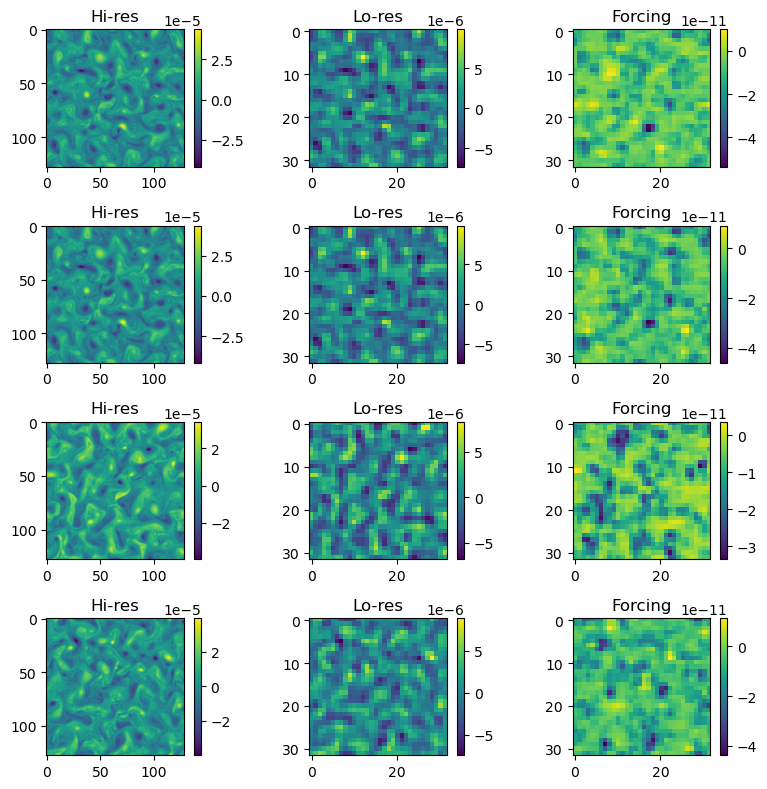

In [67]:
order = np.arange(len(hires))
np.random.shuffle(order)

from figure_grid import *
def imshow(x):
    try:
        plt.imshow(x)
    except:
        plt.imshow(x.reshape(32,32))
    plt.colorbar()
with figure_grid(4,3,rowwidth=8,rowheight=2) as g:
    for i in range(g.rows):
        g.next(title='Hi-res')
        imshow(hires[order[i]])
        g.next(title='Lo-res')
        imshow(X[order[i]])
        g.next(title='Forcing')
        imshow(Y[order[i]])

In [39]:
cnn = LargerCNN((1,32,32),(1,32,32))

In [50]:
class BasicScaler(object):
    def __init__(self):
        pass
    
    def fit(self, x):
        assert(len(x.shape)==2)
        self.mu = np.mean(x)
        self.sd = np.std(x)
        
    def transform(self, x):
        return (x - self.mu) / self.sd
    
    def inverse_transform(self, z):
        return z * self.sd + self.mu

In [51]:
X_scale = BasicScaler()
X_scale.fit(X)

Y_scale = BasicScaler()
Y_scale.fit(Y)

In [75]:
import gc
gc.collect()

cnn = LargerCNN((1,32,32),(1,32,32))
cnn.set_scales(X_scale, Y_scale)

In [76]:
def train(net, inputs, targets, num_epochs=50, batch_size=64, learning_rate=0.001):
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_steps = 0
        for x, y in minibatch(inputs, targets, batch_size=batch_size):
            optimizer.zero_grad()
            yhat = net(x)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_steps += 1
            if epoch_steps % 100 == 0:
                print(loss.item())
        print(f"Loss after Epoch {epoch+1}: {epoch_loss/epoch_steps}")

In [92]:

train(cnn, X_scale.transform(X[:N]), Y_scale.transform(Y[:N]), learning_rate=0.0001)

0.7239335775375366
0.7043843269348145
0.7258505821228027


KeyboardInterrupt: 

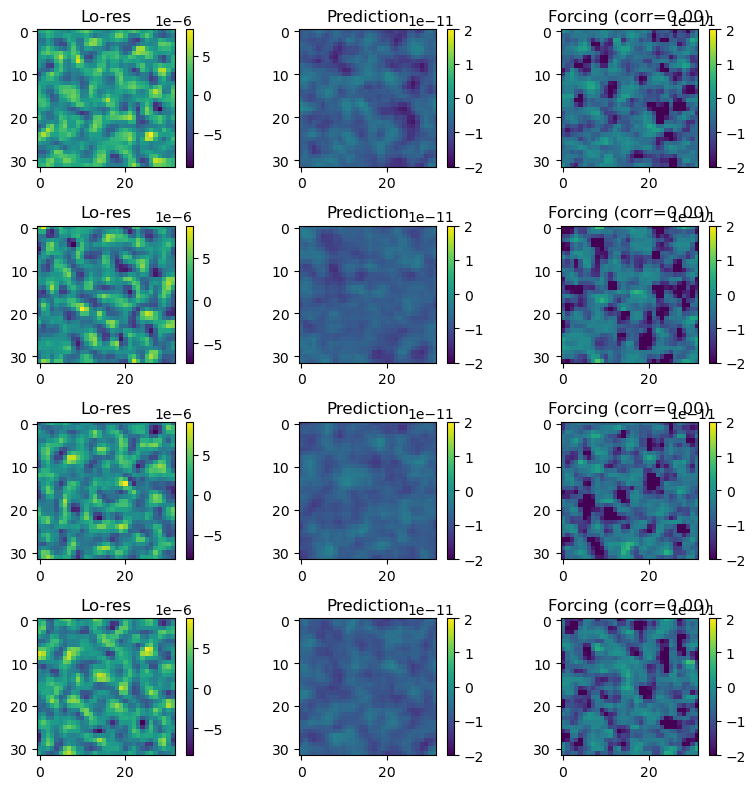

In [94]:
order = np.arange(len(X))[N:]
np.random.shuffle(order)

preds = cnn.predict(X[order[:20]])
    
def imshow(x, **kw):
    try:
        plt.imshow(x, **kw)
    except:
        plt.imshow(x.reshape(32,32), **kw)
    plt.colorbar()
    
with figure_grid(4,3,rowwidth=8,rowheight=2) as g:
    for i in range(g.rows):
        #g.next(title='Hi-res')
        #imshow(hires[N+i])
        g.next(title='Lo-res')
        imshow(X[order[i]])
        g.next(title='Prediction')
        imshow(preds[i], vmin=-2e-11, vmax=2e-11)
        corr = np.correlate(preds[i], Y[order[i]])[0]
        g.next(title=f"Forcing (corr={corr:.2f})")
        imshow(Y[order[i]], vmin=-2e-11, vmax=2e-11)
        
        
